In [336]:
import pandas as pd

df = pd.read_excel('./Data/online_retail.xlsx')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [337]:
import datetime as dt
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]
df['CustomerID'] = df['CustomerID'].astype('int')

df['Revenue'] = df['Quantity'] * df['UnitPrice']

# customer df with country 

In [338]:
customer_df =df.groupby('CustomerID')['Country'].nunique().reset_index()
customer_df[customer_df['Country']>1]

,CustomerID,Country
20,12370,2
38,12394,2
56,12417,2
60,12422,2
67,12429,2
69,12431,2
90,12455,2
92,12457,2


In [339]:
cus_df = df.groupby('CustomerID')['Country'].max().reset_index()

# Transaction trends

In [340]:

agg_df = df.groupby('InvoiceDate', as_index=False).count()
agg_df = agg_df.rename(columns={'CustomerID':'CustomerCount'})
agg_df['InvoiceDate'] = pd.to_datetime(agg_df['InvoiceDate']).dt.date


In [341]:
agg_df[['InvoiceDate']].min()

InvoiceDate    2010-12-01
dtype: object

In [342]:
agg_df[['InvoiceDate']].max()

InvoiceDate    2011-12-09
dtype: object

<Axes: xlabel='InvoiceDate'>

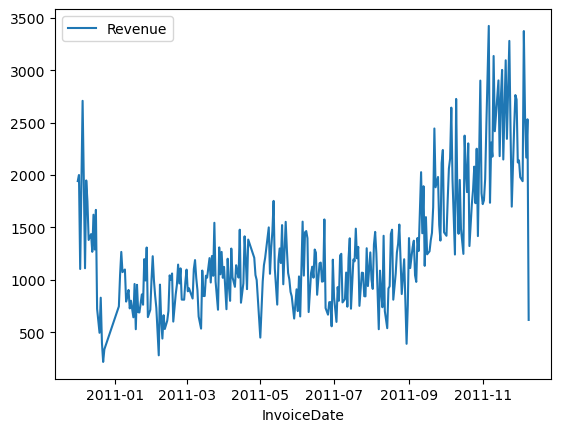

In [343]:
agg_df.plot(kind='line', x='InvoiceDate', y='Revenue')


In [344]:
#df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397924 non-null  object 
 1   StockCode    397924 non-null  object 
 2   Description  397924 non-null  object 
 3   Quantity     397924 non-null  int64  
 4   InvoiceDate  397924 non-null  object 
 5   UnitPrice    397924 non-null  float64
 6   CustomerID   397924 non-null  int64  
 7   Country      397924 non-null  object 
 8   Revenue      397924 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 30.4+ MB


# Historical Average

In [346]:
date_rng[0].date()

datetime.date(2010, 11, 30)

In [347]:
import pandas as pd
from datetime import datetime
import numpy as np
date_rng = pd.date_range(start='2010-11-30', end='2011-11-30', freq='M')
churn =  {"Month":[],"ChurnRate":[], "AvgRevenue":[]}

#append first month without churn rate
this_period  =df[(df['InvoiceDate']> date_rng[0].date()) & (df['InvoiceDate']<= date_rng[1].date()) ]['CustomerID'].unique()
total_revenue =df[(df['InvoiceDate']> date_rng[0].date()) & (df['InvoiceDate']<= date_rng[1].date()) ]['Revenue'].sum()

churn["Month"].append(date_rng[1])
churn["ChurnRate"].append(np.nan)
churn["AvgRevenue"].append(int(total_revenue/len(this_period)))

#loop through the rest of the months
for i in range(len(date_rng)):
    try:
        last_period =df[(df['InvoiceDate']> date_rng[i].date()) & (df['InvoiceDate']<= date_rng[i+1].date()) ]['CustomerID'].unique()
        this_period  =df[(df['InvoiceDate']> date_rng[i+1].date()) & (df['InvoiceDate']<= date_rng[i+2].date()) ]['CustomerID'].unique()
        total_revenue =df[(df['InvoiceDate']> date_rng[i+1].date()) & (df['InvoiceDate']<= date_rng[i+2].date()) ]['Revenue'].sum()
        retained = np.intersect1d(last_period, this_period)
        churn["Month"].append(date_rng[i+2])
        churn["ChurnRate"].append((int((1-(len(retained)/len(last_period)))*100)))
        churn["AvgRevenue"].append(int(total_revenue/len(this_period)))
    except:
        pass

In [348]:
churn_df = pd.DataFrame(churn)
churn_df

,Month,ChurnRate,AvgRevenue
0,2010-12-31,NaN,647
1,2011-01-31,63.0,768
2,2011-02-28,64.0,589
3,2011-03-31,61.0,611
4,2011-04-30,68.0,548
5,2011-05-31,57.0,642
6,2011-06-30,61.0,667
7,2011-07-31,63.0,632
8,2011-08-31,59.0,690
9,2011-09-30,54.0,752


In [349]:
churn_df.mean().round(0)

/var/folders/tw/8wdkdtvs1fv8ftrnn4f5vt540000gn/T/ipykernel_23999/694839836.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  churn_df.mean().round(0)


ChurnRate      60.0
AvgRevenue    667.0
dtype: float64

## Lifetime months

In [350]:
round(100/60,2)

1.67

## Lifetime value

In [351]:
round(667*(100/60))

1112

# RFM

In [352]:
cutoff_date = pd.to_datetime("2011-09-01").date()
end_date = pd.to_datetime("2011-12-01").date()
train_df = df.loc[df['InvoiceDate']<=cutoff_date]

In [353]:
train_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
322105,565224,82486,3 DRAWER ANTIQUE WHITE WOOD CABINET,2,2011-09-01,8.95,14713,United Kingdom,17.90
322106,565225,21288,STRIPEY CHOCOLATE NESTING BOXES,24,2011-09-01,2.55,16808,United Kingdom,61.20
322107,565225,23163,REGENCY SUGAR TONGS,8,2011-09-01,2.49,16808,United Kingdom,19.92
322108,565225,21291,SMALL POLKADOT CHOCOLATE GIFT BAG,32,2011-09-01,0.85,16808,United Kingdom,27.20


In [354]:
max_date = train_df.groupby('CustomerID', as_index=False).agg({'InvoiceDate':'max'})
max_date = max_date.rename(columns={"InvoiceDate": "MaxDate"}).set_index('CustomerID')
min_date = train_df.groupby('CustomerID', as_index=False).agg({'InvoiceDate':'min'})
min_date = min_date.rename(columns={"InvoiceDate": "MinDate"}).set_index('CustomerID')
freqeuncy = train_df.groupby('CustomerID', as_index=False).agg({'Revenue':'count'})
freqeuncy = freqeuncy.rename(columns={"Revenue": "Freqeuncy"}).set_index('CustomerID')
monetary = train_df.groupby('CustomerID', as_index=False).agg({'Revenue':'sum'})
monetary = monetary.rename(columns={"Revenue": "Monetary"}).set_index('CustomerID')


In [355]:
rmf_df = max_date.merge(min_date, left_index=True, right_index=True)\
    .merge(freqeuncy, left_index=True, right_index=True)\
        .merge(monetary, left_index=True, right_index=True).reset_index()

In [356]:
import numpy as np
rmf_df['CutoffDate'] = cutoff_date
rmf_df[['MinDate','MaxDate','CutoffDate']] = rmf_df[['MinDate','MaxDate', 'CutoffDate']].apply(pd.to_datetime)
#calculate difference between dates
rmf_df['Tenure'] = (rmf_df['CutoffDate'] - rmf_df['MinDate'])  / np.timedelta64(1, 'D')
rmf_df['Recency'] = (rmf_df['CutoffDate'] - rmf_df['MaxDate'])  / np.timedelta64(1, 'D')
rmf_df['Churn'] = rmf_df['Recency'].apply(lambda x: 1 if x >1 else 0)

In [357]:
rmf_df

,CustomerID,MaxDate,MinDate,Freqeuncy,Monetary,CutoffDate,Tenure,Recency,Churn
0,12346,2011-01-18,2011-01-18,1,77183.60,2011-09-01,226.0,226.0,1
1,12347,2011-08-02,2010-12-07,124,2790.86,2011-09-01,268.0,30.0,1
2,12348,2011-04-05,2010-12-16,28,1487.24,2011-09-01,259.0,149.0,1
3,12350,2011-02-02,2011-02-02,17,334.40,2011-09-01,211.0,211.0,1
4,12352,2011-03-22,2011-02-16,38,1561.81,2011-09-01,197.0,163.0,1
...,...,...,...,...,...,...,...,...,...
3319,18280,2011-03-07,2011-03-07,10,180.60,2011-09-01,178.0,178.0,1
3320,18281,2011-06-12,2011-06-12,7,80.82,2011-09-01,81.0,81.0,1
3321,18282,2011-08-05,2011-08-05,7,100.21,2011-09-01,27.0,27.0,1
3322,18283,2011-07-14,2011-01-06,400,985.77,2011-09-01,238.0,49.0,1


In [358]:
country_rmf_df =rmf_df.merge(cus_df, on=['CustomerID'])
country_rmf_df['CountryGroup'] = country_rmf_df['Country'].apply(lambda x: 'United Kingdom' if x =='United Kingdom' else 'Others')
country_rmf_df['TenureMonth'] =  country_rmf_df['Tenure']/30.5
country_rmf_df['TenureMonth'] = country_rmf_df['TenureMonth'].astype('int')

In [359]:
country_rmf_df

,CustomerID,MaxDate,MinDate,Freqeuncy,Monetary,CutoffDate,Tenure,Recency,Churn,Country,CountryGroup,TenureMonth
0,12346,2011-01-18,2011-01-18,1,77183.60,2011-09-01,226.0,226.0,1,United Kingdom,United Kingdom,7
1,12347,2011-08-02,2010-12-07,124,2790.86,2011-09-01,268.0,30.0,1,Iceland,Others,8
2,12348,2011-04-05,2010-12-16,28,1487.24,2011-09-01,259.0,149.0,1,Finland,Others,8
3,12350,2011-02-02,2011-02-02,17,334.40,2011-09-01,211.0,211.0,1,Norway,Others,6
4,12352,2011-03-22,2011-02-16,38,1561.81,2011-09-01,197.0,163.0,1,Norway,Others,6
...,...,...,...,...,...,...,...,...,...,...,...,...
3319,18280,2011-03-07,2011-03-07,10,180.60,2011-09-01,178.0,178.0,1,United Kingdom,United Kingdom,5
3320,18281,2011-06-12,2011-06-12,7,80.82,2011-09-01,81.0,81.0,1,United Kingdom,United Kingdom,2
3321,18282,2011-08-05,2011-08-05,7,100.21,2011-09-01,27.0,27.0,1,United Kingdom,United Kingdom,0
3322,18283,2011-07-14,2011-01-06,400,985.77,2011-09-01,238.0,49.0,1,United Kingdom,United Kingdom,7


# Kaplan Meier

In [360]:
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test

In [361]:
kmf = KaplanMeierFitter()
 
T=country_rmf_df['TenureMonth']
C=country_rmf_df['Churn'].astype(float)
 
kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3324 total observations, 106 right-censored observations>

<Axes: title={'center': 'Kaplan-Meier Survival Curve'}, xlabel='timeline'>

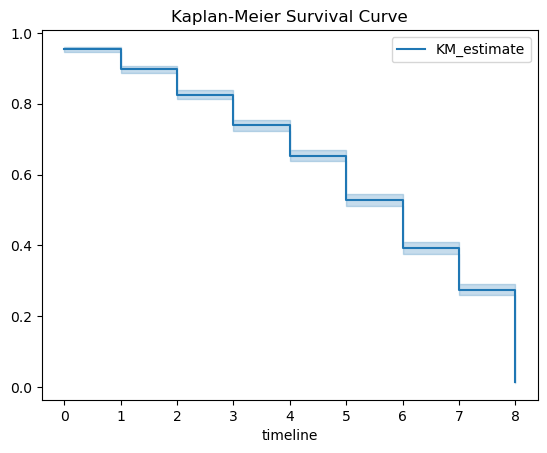

In [362]:
kmf.plot(title='Kaplan-Meier Survival Curve')

In [363]:
kmf.median_survival_time_

6.0

In [364]:
pd.DataFrame(kmf.survival_function_at_times(range(0,7)))

,KM_estimate
0,0.953971
1,0.897162
2,0.826055
3,0.739660
4,0.653801
5,0.527298
6,0.393716


In [387]:
# Construct dataframe with values from widgets

 
def get_payback_df():
  irr = 0
  cohort_df = pd.concat([pd.DataFrame([1.00]),kmf.survival_function_at_times(range(1,7))]).rename(columns={0:'Survival Probability'})
  cohort_df['Contract Month'] = cohort_df.index.astype('int')
  cohort_df['Monthly Profit for the Selected Plan'] = 667
  cohort_df['Avg Expected Monthly Profit'] = round(cohort_df['Survival Probability'] * cohort_df['Monthly Profit for the Selected Plan'],2)
  cohort_df['NPV of Avg Expected Monthly Profit'] = round(cohort_df['Avg Expected Monthly Profit'] / ((1+irr)**cohort_df['Contract Month']),2)
  cohort_df['Cumulative NPV'] = cohort_df['NPV of Avg Expected Monthly Profit'].cumsum()
  cohort_df['Contract Month'] = cohort_df['Contract Month'] + 1
  return cohort_df[['Contract Month','Survival Probability','Monthly Profit for the Selected Plan','Avg Expected Monthly Profit','NPV of Avg Expected Monthly Profit','Cumulative NPV']].set_index('Contract Month')


In [388]:
get_payback_df()

,Survival Probability,Monthly Profit for the Selected Plan,Avg Expected Monthly Profit,NPV of Avg Expected Monthly Profit,Cumulative NPV
Contract Month,,,,,
1,1.000000,667,667.00,667.00,667.00
2,0.901569,667,601.35,601.35,1268.35
3,0.831701,667,554.74,554.74,1823.09
4,0.745535,667,497.27,497.27,2320.36
5,0.657607,667,438.62,438.62,2758.98
6,0.527234,667,351.67,351.67,3110.65
7,0.394067,667,262.84,262.84,3373.49


In [367]:
import matplotlib.pyplot as plt
# Helper function for plotting Kaplan-Meier curves at the covariate level
def plot_km(col):
  ax = plt.subplot(111)
  for r in country_rmf_df[col].unique():
    ix = country_rmf_df[col] == r
    kmf.fit(T[ix], C[ix],label=r)
    kmf.plot(ax=ax)
    
# Helper function for printing out Log-rank test results
def print_logrank(col):
  log_rank = pairwise_logrank_test(country_rmf_df['TenureMonth'], country_rmf_df[col], country_rmf_df['Churn'])
  return log_rank.summary

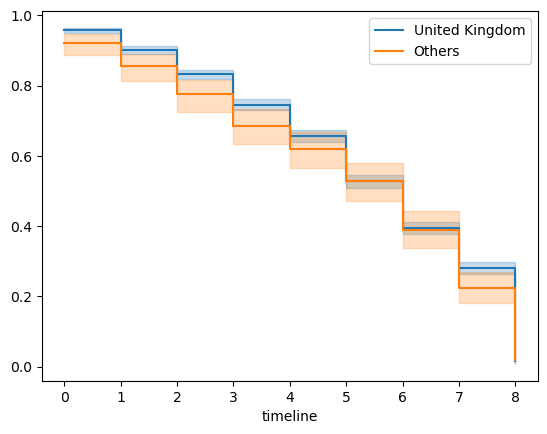

In [368]:
plot_km('CountryGroup')

In [369]:
print_logrank('CountryGroup')

,,test_statistic,p,-log2(p)
Others,United Kingdom,2.885866,0.08936,3.484228


In [370]:
kmf.median_survival_time_

6.0

In [371]:
def get_survival_probs(col,val):
  ix = country_rmf_df[col] == val
  return kmf.fit(T[ix],C[ix],label=val)  

In [372]:
sp_internet_dsl = get_survival_probs('Country','United Kingdom')

In [373]:
pd.DataFrame(sp_internet_dsl.survival_function_at_times(range(0,10)))

,United Kingdom
0,0.957582
1,0.901569
2,0.831701
3,0.745535
4,0.657607
5,0.527234
6,0.394067
7,0.280794
8,0.015159
9,0.015159


# Cox

In [405]:
encode_cols = ['CountryGroup']
 
encoded_pd = pd.get_dummies(country_rmf_df,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)
 
encoded_pd.head()

,CustomerID,MaxDate,MinDate,Freqeuncy,Monetary,CutoffDate,Tenure,Recency,Churn,Country,TenureMonth,CountryGroup_Others,CountryGroup_United Kingdom
0,12346,2011-01-18,2011-01-18,1,77183.60,2011-09-01,226.0,226.0,1,United Kingdom,7,0,1
1,12347,2011-08-02,2010-12-07,124,2790.86,2011-09-01,268.0,30.0,1,Iceland,8,1,0
2,12348,2011-04-05,2010-12-16,28,1487.24,2011-09-01,259.0,149.0,1,Finland,8,1,0
3,12350,2011-02-02,2011-02-02,17,334.40,2011-09-01,211.0,211.0,1,Norway,6,1,0
4,12352,2011-03-22,2011-02-16,38,1561.81,2011-09-01,197.0,163.0,1,Norway,6,1,0


In [406]:
survival_pd = encoded_pd[['Churn','TenureMonth','CountryGroup_Others','CountryGroup_United Kingdom']]

In [407]:
survival_pd.loc[:,'Churn'] = survival_pd.loc[:,'Churn'].astype('float')
survival_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3324 entries, 0 to 3323
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        3324 non-null   float64
 1   TenureMonth                  3324 non-null   int64  
 2   CountryGroup_Others          3324 non-null   uint8  
 3   CountryGroup_United Kingdom  3324 non-null   uint8  
dtypes: float64(1), int64(1), uint8(2)
memory usage: 213.4 KB


/var/folders/tw/8wdkdtvs1fv8ftrnn4f5vt540000gn/T/ipykernel_23999/2656172636.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  survival_pd.loc[:,'Churn'] = survival_pd.loc[:,'Churn'].astype('float')


In [408]:
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter

cph = CoxPHFitter(alpha=0.01,penalizer=0.01)
cph.fit(survival_pd, 'TenureMonth', 'Churn')

<lifelines.CoxPHFitter: fitted with 3324 total observations, 106 right-censored observations>

In [409]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3324 total observations, 106 right-censored observations>
             duration col = 'TenureMonth'
                event col = 'Churn'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 3324
number of events observed = 3218
   partial log-likelihood = -23062.65
         time fit was run = 2023-05-01 11:37:47 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 99%   coef upper 99%  exp(coef) lower 99%  exp(coef) upper 99%
covariate                                                                                                                           
CountryGroup_Others           0.04       1.04       0.41            -1.02             1.10                 0.36                 2.99
CountryGroup_United Kingdom  -0.04       0.96       0.41            -1.10             1.02                 0.33                 2.78

                              cmp to     z    p   -log2(p)
covariate                                                 
CountryGroup_Others             0.00  0.09 0.93       0.11
CountryGroup_United Kingdom     0.00 -0.09 0.93       0.11
---
Concordance = 0.51
Partial AIC = 46129.31
log-likelihood ratio test = 1.58 on 2 df
-log2(p) of ll-ratio test = 1.14

<Axes: xlabel='HR (99% CI)'>

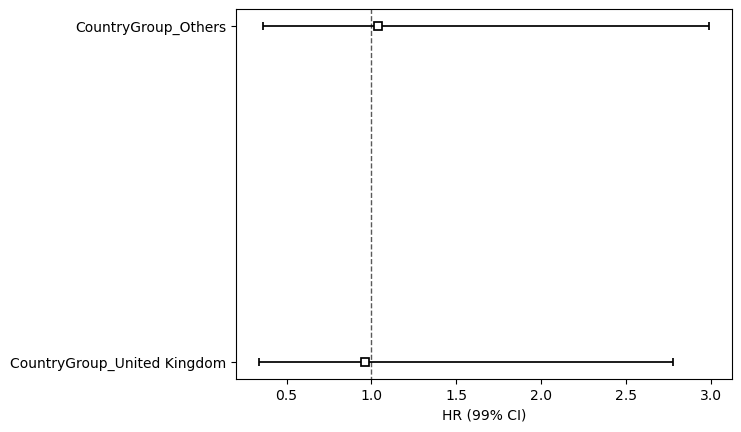

In [410]:
cph.plot(hazard_ratios=True)

In [411]:
cph.check_assumptions(survival_pd,p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

In [414]:
 widget_dict= {'CountryGroup_Others':0,	'CountryGroup_United Kingdom':0,' internal rate of return':0.10}
 df = pd.DataFrame.from_dict(widget_dict,orient='index').T

In [415]:
cph.predict_survival_function(df)

,0
0.0,0.953691
1.0,0.896930
2.0,0.826585
3.0,0.742122
4.0,0.658440
5.0,0.539412
6.0,0.415521
7.0,0.304710
8.0,0.115113


In [418]:
# Construct dataframe with values from widgets

 
def get_payback_df():
  irr = df[' internal rate of return'].astype('float64')[0]/12
  cohort_df = pd.concat([round(cph.predict_survival_function(df),2)]).rename(columns={0:'Survival Probability'})
  cohort_df['Contract Month'] = cohort_df.index.astype('int')
  cohort_df['Monthly Profit for the Selected Plan'] = 667
  cohort_df['Avg Expected Monthly Profit'] = round(cohort_df['Survival Probability'] * cohort_df['Monthly Profit for the Selected Plan'],2)
  cohort_df['NPV of Avg Expected Monthly Profit'] = round(cohort_df['Avg Expected Monthly Profit'] / ((1+irr)**cohort_df['Contract Month']),2)
  cohort_df['Cumulative NPV'] = cohort_df['NPV of Avg Expected Monthly Profit'].cumsum()
  cohort_df['Contract Month'] = cohort_df['Contract Month'] + 1
  return cohort_df[['Contract Month','Survival Probability','Monthly Profit for the Selected Plan','Avg Expected Monthly Profit','NPV of Avg Expected Monthly Profit','Cumulative NPV']].set_index('Contract Month')


In [419]:
pd.options.display.max_rows = 25
get_payback_df()[0:25]

,Survival Probability,Monthly Profit for the Selected Plan,Avg Expected Monthly Profit,NPV of Avg Expected Monthly Profit,Cumulative NPV
Contract Month,,,,,
1,0.95,667,633.65,633.65,633.65
2,0.90,667,600.30,595.34,1228.99
3,0.83,667,553.61,544.50,1773.49
4,0.74,667,493.58,481.44,2254.93
5,0.66,667,440.22,425.85,2680.78
6,0.54,667,360.18,345.54,3026.32
7,0.42,667,280.14,266.53,3292.85
8,0.30,667,200.10,188.81,3481.66
9,0.12,667,80.04,74.90,3556.56


# BD/NBD

In [398]:
from lifetimes.plotting import *
from lifetimes.utils import *

data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-06-01')
data.head()

KeyError: "None of [Index(['CustomerID', 'InvoiceDate', 'Sales'], dtype='object')] are in the [columns]"

In [ ]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

In [ ]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

In [ ]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [ ]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

In [ ]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [ ]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-01',
                                        observation_period_end='2011-12-01' )   
print(summary_cal_holdout.head())

In [ ]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [ ]:
t = 10
individual = data.loc[12347]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

In [ ]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = 14606
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

In [ ]:
fig = plt.figure(figsize=(12,8))
id = 14729
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

In [ ]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

In [ ]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)


In [ ]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))